# Лабораторная работа №2
Пан Анатолий Эдуардович<br>
Группа 932209<br>
Вариант: г.Якутск

Прежде чем начать работу, подключимся к Google Drive

In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Сменим рабочее пространство

In [2]:
# Change directory
import os
os.chdir("/content/drive/MyDrive/masters/DL/labs")

## Установим необходимые библиотеки

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Подготовка данных

Откроем необходимые данные

In [4]:
df = pd.read_csv("Yakutsk_weather_19102020_01102012.csv", encoding='cp1251', sep=";")
df.head()

,LocalTime,T,P0,P,U,DD
0,19.10.2020 17:00,-7.0,745.9,758.2,68.0,Ветер
1,19.10.2020 16:30,-6.0,746.0,758.2,63.0,Ветер
2,19.10.2020 16:00,-5.0,746.0,758.2,58.0,Ветер
3,19.10.2020 15:30,-4.0,746.1,758.2,59.0,Ветер
4,19.10.2020 15:00,-4.0,746.1,758.2,54.0,Ветер


Посмотрим на размерность набора данных

In [5]:
df.shape

(116051, 6)

Проверим данные на пустые значения. Если таковые будут, то удалим их

In [6]:
df.isna().sum()

LocalTime    0
T            1
P0           2
P            2
U            3
DD           3
dtype: int64

In [7]:
df = df.dropna()

В рамках лабораторной работы требуется использовать следующие признаки: T, P0, P, U

In [8]:
df = df.drop(["DD"], axis=1)

In [9]:
df.shape

(116044, 5)

Визуализируем данные

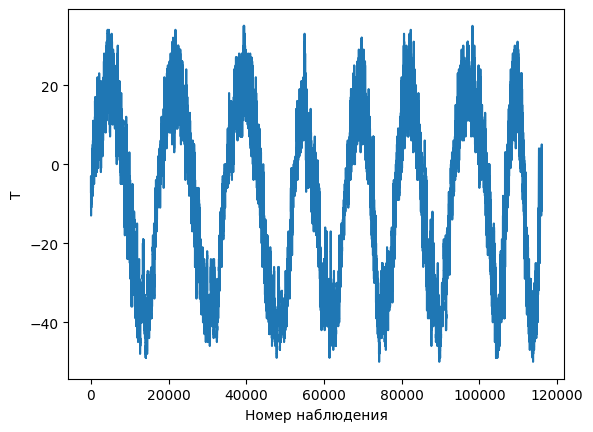

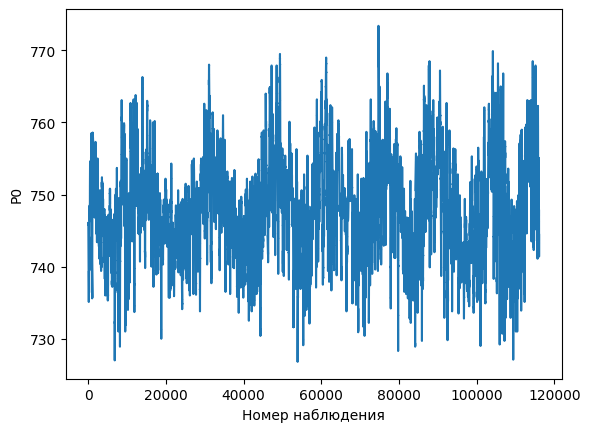

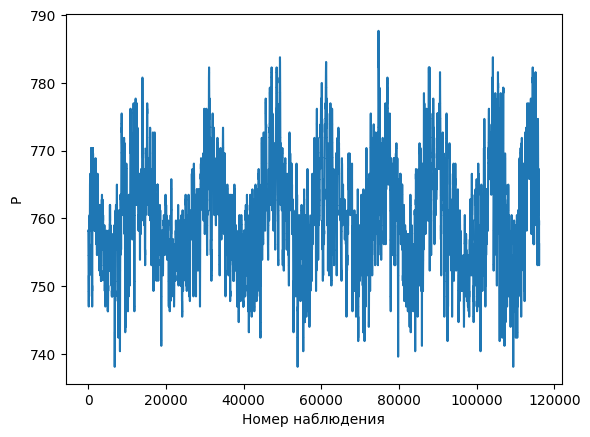

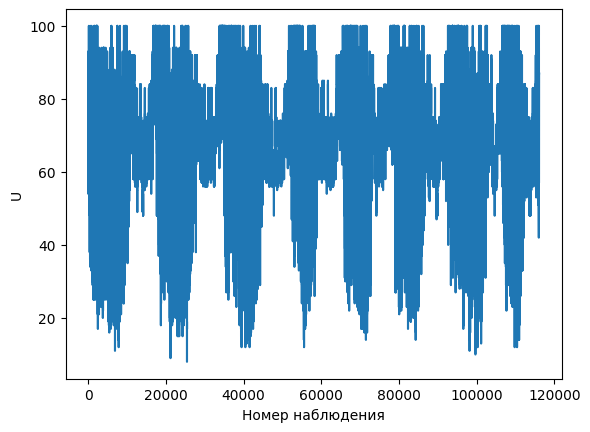

In [10]:
for i, col in enumerate(df.columns[1:]):
    plt.plot(df[col])
    plt.xlabel('Номер наблюдения')
    plt.ylabel(col)
    plt.show()
    print()

Разделим данные на признаки и таргет

In [11]:
X = df[["P0", "P", "U"]]
y = df["T"]

Выполним разделение данных на обучающий, валидационный и тестовый наборы

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Выполним масштабирование данных

In [13]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [14]:
X_train_rnn = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_rnn = np.reshape(X_val_scaled, (X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_rnn = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

#a)

## a) Регрессор, использующий слой RNN в качестве скрытого слоя

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout

Построение модели

In [21]:
model_a_1 = Sequential([
    SimpleRNN(units=64, activation="relu", input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(units=1, activation="linear")
])

Компиляция модели

In [22]:
model_a_1.compile(optimizer="adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

In [23]:
model_a_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4417 (17.25 KB)
Trainable params: 4417 (17.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели

In [24]:
history_a_1 = model_a_1.fit(X_train_rnn, y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_val_rnn, y_val))

Epoch 1/25
2539/2539 [==============================] - 9s 3ms/step - loss: 353.9829 - mean_absolute_error: 16.2322 - val_loss: 288.3991 - val_mean_absolute_error: 14.3419
Epoch 2/25
2539/2539 [==============================] - 9s 3ms/step - loss: 268.3050 - mean_absolute_error: 13.7054 - val_loss: 258.7486 - val_mean_absolute_error: 13.4741
Epoch 3/25
2539/2539 [==============================] - 7s 3ms/step - loss: 241.4671 - mean_absolute_error: 12.9134 - val_loss: 233.8802 - val_mean_absolute_error: 12.7001
Epoch 4/25
2539/2539 [==============================] - 9s 4ms/step - loss: 221.0020 - mean_absolute_error: 12.3196 - val_loss: 214.5876 - val_mean_absolute_error: 12.1514
Epoch 5/25
2539/2539 [==============================] - 7s 3ms/step - loss: 202.1137 - mean_absolute_error: 11.7738 - val_loss: 194.9367 - val_mean_absolute_error: 11.5330
Epoch 6/25
2539/2539 [==============================] - 9s 3ms/step - loss: 180.8493 - mean_absolute_error: 11.1352 - val_loss: 170.8212 - v

Визуализируем лосс и метрики MAE, MSE

In [25]:
def plot_metrics(parameter, history, model):
    metrics = history.history[parameter]
    val_metrics = history.history['val_' + parameter]
    epochs = range(1, len(metrics) + 1)
    plt.plot(epochs, metrics, 'y', label='Training ' + parameter)
    plt.plot(epochs, val_metrics, 'r', label='Validation ' + parameter)
    plt.title('Training and validation ' + parameter + ' for model ' + model)
    plt.xlabel('Epochs')
    plt.ylabel(parameter)
    plt.legend()
    plt.show()
    print()

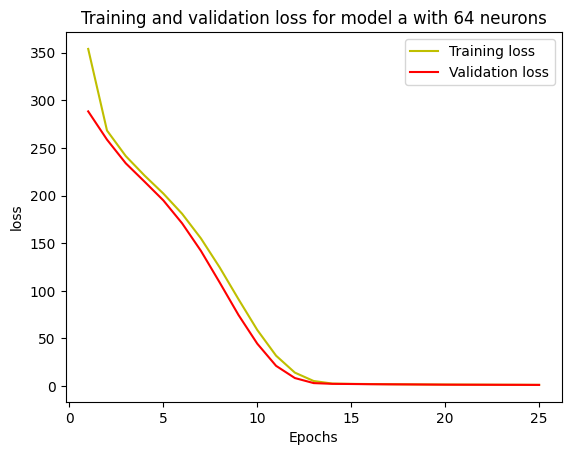

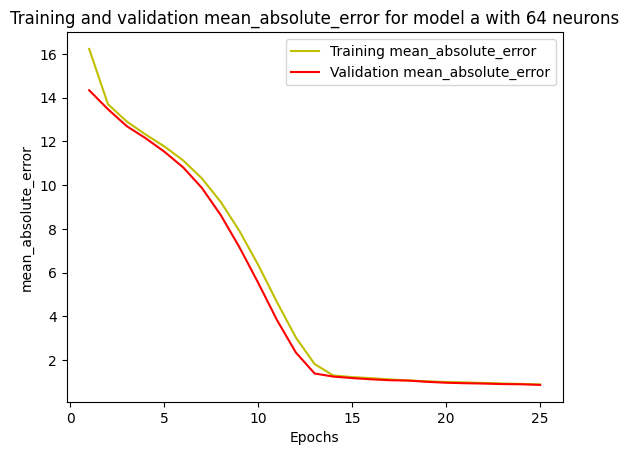

In [26]:
plot_metrics("loss", history_a_1, "a with 64 neurons")
plot_metrics("mean_absolute_error", history_a_1, "a with 64 neurons")

Предсказание на тестовой выборке

In [27]:
y_pred_a_1 = model_a_1.predict(X_test_rnn)

544/544 [==============================] - 1s 2ms/step


Вычисление метрик

In [28]:
# Вычисление метрик
r2_a_1 = r2_score(y_test, y_pred_a_1)
mse_a_1 = mean_squared_error(y_test, y_pred_a_1)
mae_a_1 = mean_absolute_error(y_test, y_pred_a_1)

In [29]:
# Вывод метрик
print(f'R^2 Score: {r2_a_1}')
print(f'Mean Squared Error: {mse_a_1}')
print(f'Mean Absolute Error: {mae_a_1}')

R^2 Score: 0.9975135685242686
Mean Squared Error: 1.1570161895264723
Mean Absolute Error: 0.8612784710950551


Визуализируем предсказание на небольшом участке для наглядности

In [30]:
def plot_result(testY, test_predict, model, a, b):
    actual = testY
    predictions = test_predict
    rows = len(actual)
    plt.figure(figsize=(15, 6),dpi=100)
    plt.plot(range(rows), actual, linewidth=0.9)
    plt.plot(range(rows), predictions, linewidth=0.7)
    plt.xlim(a, b)
    plt.legend(['Реальная температура', 'Предсказание'])
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Отмасштабированная температура')
    plt.title(f'Реальная и предсказанная температура ({model})')

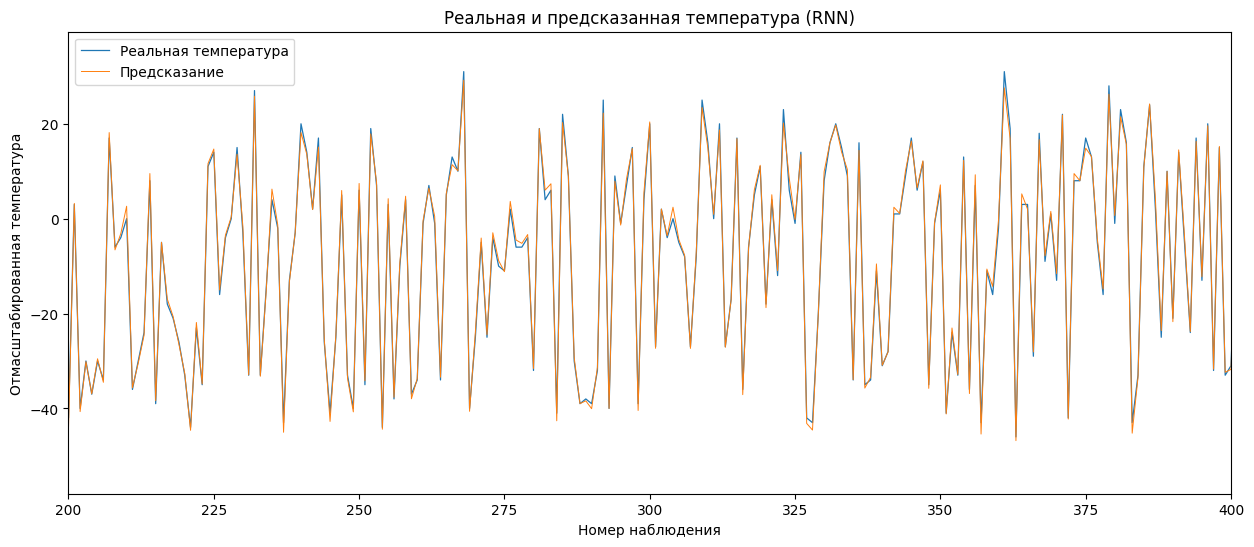

In [31]:
plot_result(y_test, y_pred_a_1, "RNN", 200, 400)

Рассмотрим еще вариант

## a) Регрессор, использующий слой RNN в качестве скрытого слоя

Построение модели

In [37]:
model_a_2 = Sequential([
    SimpleRNN(units=8, activation="relu", input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(units=1, activation="linear")
])

Компиляция модели

In [38]:
model_a_2.compile(optimizer="adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

In [39]:
model_a_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 8)                 96        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 105 (420.00 Byte)
Trainable params: 105 (420.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели

In [40]:
history_a_2 = model_a_2.fit(X_train_rnn, y_train,
            epochs=30,
            batch_size=32,
            validation_data=(X_val_rnn, y_val))

Epoch 1/30
2539/2539 [==============================] - 8s 3ms/step - loss: 417.4980 - mean_absolute_error: 17.9477 - val_loss: 360.6859 - val_mean_absolute_error: 16.7368
Epoch 2/30
2539/2539 [==============================] - 10s 4ms/step - loss: 315.6454 - mean_absolute_error: 15.3389 - val_loss: 289.9940 - val_mean_absolute_error: 14.4745
Epoch 3/30
2539/2539 [==============================] - 10s 4ms/step - loss: 274.1958 - mean_absolute_error: 13.8852 - val_loss: 268.6595 - val_mean_absolute_error: 13.6570
Epoch 4/30
2539/2539 [==============================] - 10s 4ms/step - loss: 258.2574 - mean_absolute_error: 13.3411 - val_loss: 256.5994 - val_mean_absolute_error: 13.2530
Epoch 5/30
2539/2539 [==============================] - 8s 3ms/step - loss: 248.2693 - mean_absolute_error: 13.0368 - val_loss: 248.3506 - val_mean_absolute_error: 12.9907
Epoch 6/30
2539/2539 [==============================] - 9s 4ms/step - loss: 241.0140 - mean_absolute_error: 12.8260 - val_loss: 241.3835 

Визуализируем лосс и метрики MAE, MSE

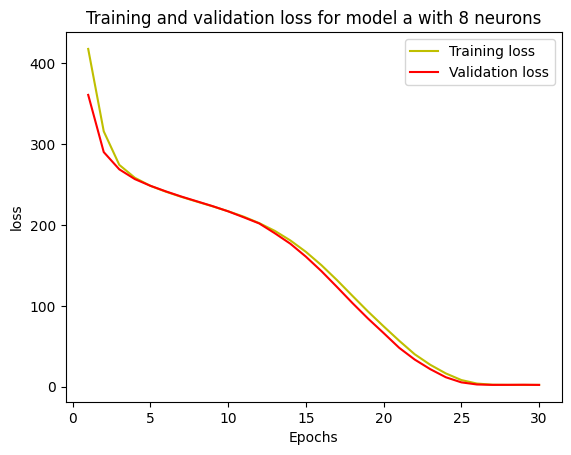

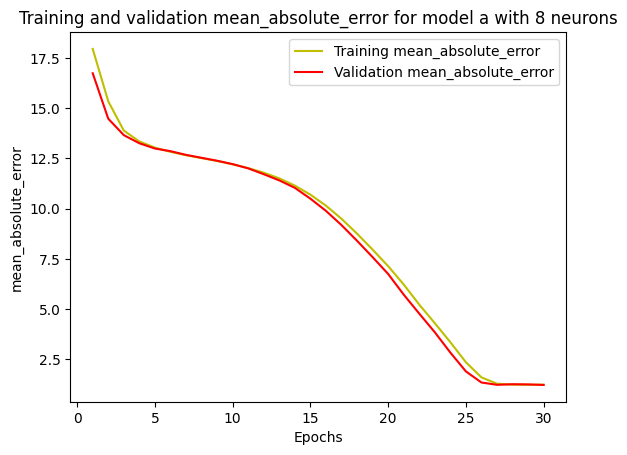

In [41]:
plot_metrics("loss", history_a_2, "a with 8 neurons")
plot_metrics("mean_absolute_error", history_a_2, "a with 8 neurons")

Предсказание на тестовой выборке

In [42]:
y_pred_a_2 = model_a_2.predict(X_test_rnn)

544/544 [==============================] - 1s 2ms/step


Вычисление метрик

In [43]:
# Вычисление метрик
r2_a_2 = r2_score(y_test, y_pred_a_2)
mse_a_2 = mean_squared_error(y_test, y_pred_a_2)
mae_a_2 = mean_absolute_error(y_test, y_pred_a_2)

In [44]:
# Вывод метрик
print(f'R^2 Score: {r2_a_2}')
print(f'Mean Squared Error: {mse_a_2}')
print(f'Mean Absolute Error: {mae_a_2}')

R^2 Score: 0.995245669898251
Mean Squared Error: 2.2123420459269014
Mean Absolute Error: 1.2191517570698536


Визуализируем предсказание на небольшом участке для наглядности

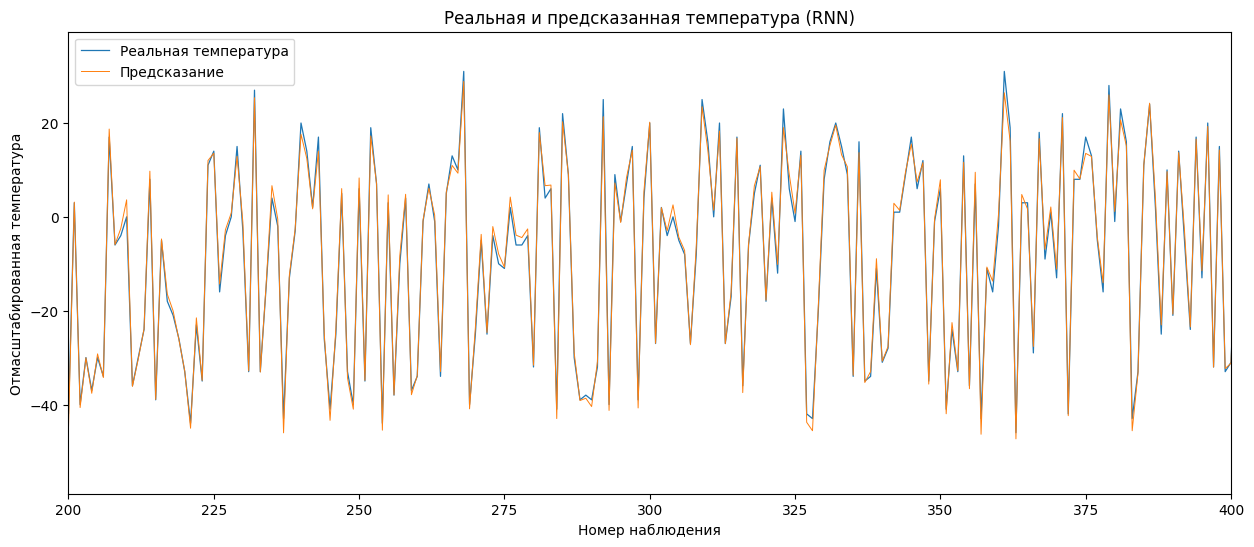

In [45]:
plot_result(y_test, y_pred_a_2, "RNN", 200, 400)

Сравним результаты двух моделей

In [47]:
print(f'R^2 Score:\t\t1) {r2_a_1}\t2) {r2_a_2}')
print(f'Mean Squared Error:\t1) {mse_a_1}\t2) {mse_a_2}')
print(f'Mean Absolute Error:\t1) {mae_a_1}\t2) {mae_a_2}')

R^2 Score:		1) 0.9975135685242686	2) 0.995245669898251
Mean Squared Error:	1) 1.1570161895264723	2) 2.2123420459269014
Mean Absolute Error:	1) 0.8612784710950551	2) 1.2191517570698536


Как можно видеть из метрик, то модель с 64 нейронами показывает результаты чуть лучше, чем с 8

Посмотрим на визуализацию loss

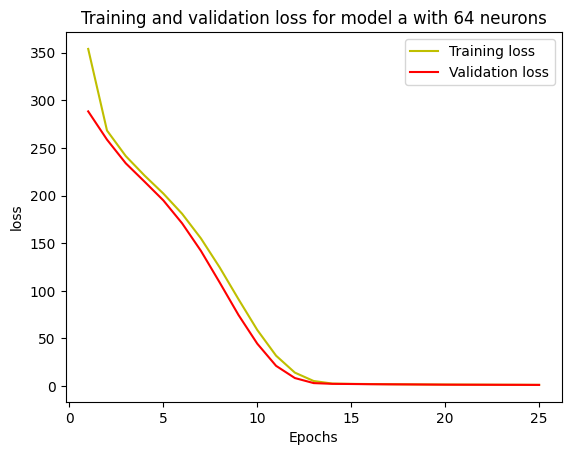

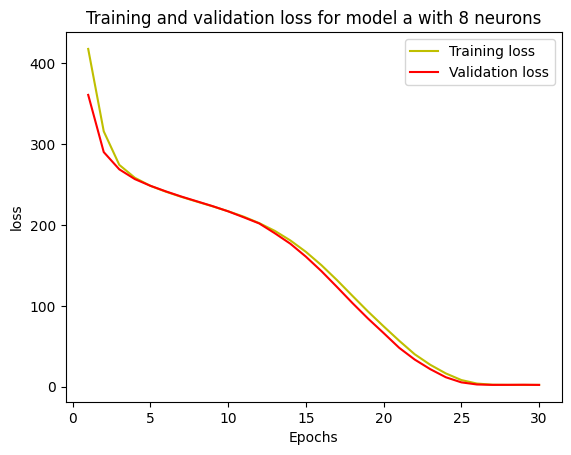

In [49]:
plot_metrics("loss", history_a_1, "a with 64 neurons")
plot_metrics("loss", history_a_2, "a with 8 neurons")

Для первой модели требуется меньше эпох, чтобы лосс начал принимать "постоянное" значение

Попробуем добавить `dropout` во вторую модель, чтобы улучшить ее результаты

**dropout** — метод регуляризации искусственных нейронных сетей, предназначен для уменьшения переобучения сети за счет предотвращения сложных коадаптаций отдельных нейронов на тренировочных данных во время обучения

In [50]:
from tensorflow.keras.layers import Dropout

Построение модели

In [55]:
model_a_dropout = Sequential([
    SimpleRNN(units=8, activation="relu", input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.2),
    Dense(units=1, activation="linear")
])

Компиляция модели

In [56]:
model_a_dropout.compile(optimizer="adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

In [57]:
model_a_dropout.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 8)                 96        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 105 (420.00 Byte)
Trainable params: 105 (420.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели

In [58]:
history_a_dropout = model_a_dropout.fit(X_train_rnn, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_val_rnn, y_val))

Epoch 1/50
2539/2539 [==============================] - 9s 3ms/step - loss: 424.5894 - mean_absolute_error: 17.8931 - val_loss: 360.3407 - val_mean_absolute_error: 16.6206
Epoch 2/50
2539/2539 [==============================] - 9s 4ms/step - loss: 344.8400 - mean_absolute_error: 15.9446 - val_loss: 308.8857 - val_mean_absolute_error: 15.0635
Epoch 3/50
2539/2539 [==============================] - 8s 3ms/step - loss: 314.5399 - mean_absolute_error: 14.9588 - val_loss: 290.9135 - val_mean_absolute_error: 14.4303
Epoch 4/50
2539/2539 [==============================] - 9s 4ms/step - loss: 296.1664 - mean_absolute_error: 14.4157 - val_loss: 278.2374 - val_mean_absolute_error: 14.0171
Epoch 5/50
2539/2539 [==============================] - 8s 3ms/step - loss: 281.2820 - mean_absolute_error: 13.9771 - val_loss: 262.4342 - val_mean_absolute_error: 13.4959
Epoch 6/50
2539/2539 [==============================] - 9s 4ms/step - loss: 267.1120 - mean_absolute_error: 13.5828 - val_loss: 249.1991 - v

Визуализируем лосс и метрики MAE, MSE

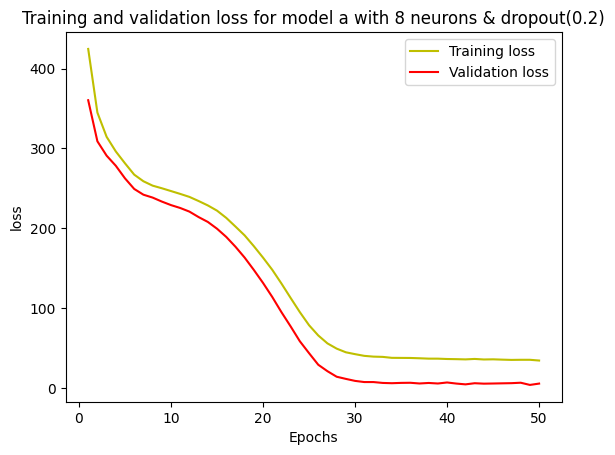

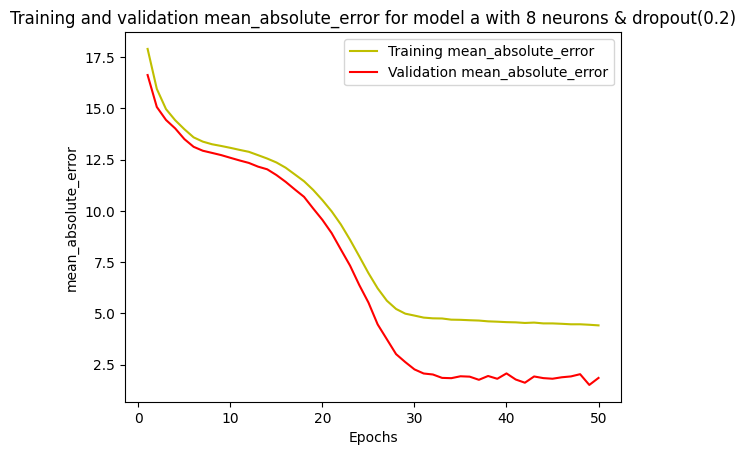

In [59]:
plot_metrics("loss", history_a_dropout, "a with 8 neurons & dropout(0.2)")
plot_metrics("mean_absolute_error", history_a_dropout, "a with 8 neurons & dropout(0.2)")

Предсказание на тестовой выборке

In [60]:
y_pred_a_dropout = model_a_dropout.predict(X_test_rnn)

544/544 [==============================] - 1s 2ms/step


Вычисление метрик

In [61]:
# Вычисление метрик
r2_a_dropout = r2_score(y_test, y_pred_a_dropout)
mse_a_dropout = mean_squared_error(y_test, y_pred_a_dropout)
mae_a_dropout = mean_absolute_error(y_test, y_pred_a_dropout)

In [62]:
# Вывод метрик
print(f'R^2 Score: {r2_a_dropout}')
print(f'Mean Squared Error: {mse_a_dropout}')
print(f'Mean Absolute Error: {mae_a_dropout}')

R^2 Score: 0.988494429338621
Mean Squared Error: 5.353910475670989
Mean Absolute Error: 1.8467602797596063


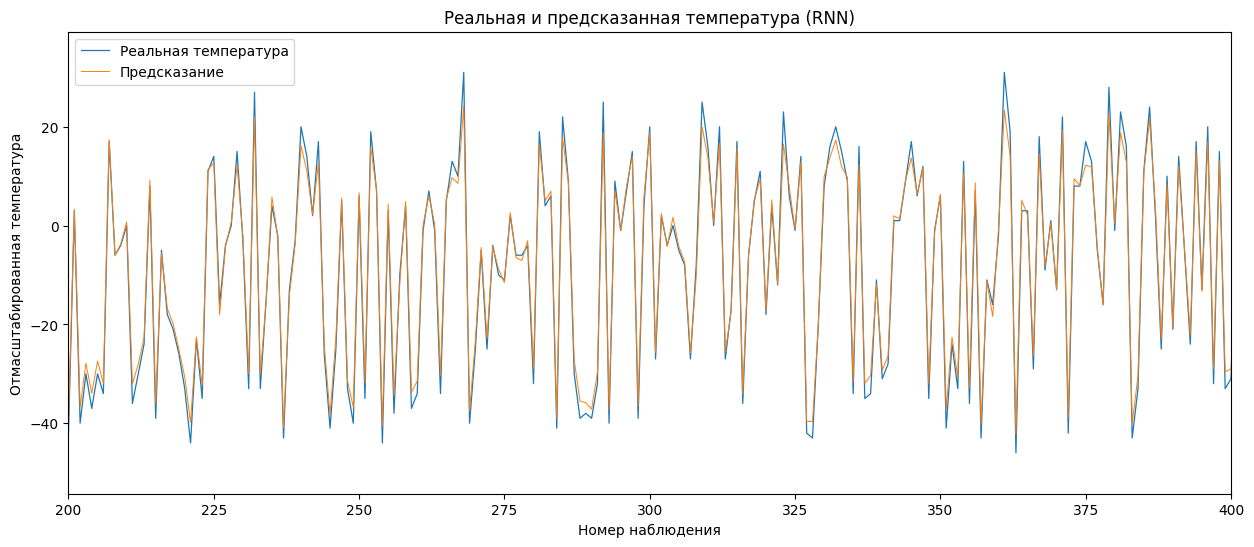

In [63]:
plot_result(y_test, y_pred_a_dropout, "RNN", 200, 400)

Dropout в данном случае не приносит никаких улучшений, я думаю, что здесь его использование совсем не обязательно

#b)

## b) Регрессор, ячейку LSTM (или GRU) в скрытом слое

In [64]:
from tensorflow.keras.layers import LSTM

Построение модели

In [65]:
model_b_1 = Sequential([
    LSTM(units=64, activation="relu", input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(units=1, activation="linear")
])

Компиляция модели

In [66]:
model_b_1.compile(optimizer="adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

In [67]:
model_b_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17473 (68.25 KB)
Trainable params: 17473 (68.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели

In [68]:
history_b_1 = model_b_1.fit(X_train_rnn, y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_val_rnn, y_val))

Epoch 1/25
2539/2539 [==============================] - 19s 6ms/step - loss: 349.4841 - mean_absolute_error: 16.0012 - val_loss: 287.9415 - val_mean_absolute_error: 14.2831
Epoch 2/25
2539/2539 [==============================] - 9s 4ms/step - loss: 271.9202 - mean_absolute_error: 13.7607 - val_loss: 264.7295 - val_mean_absolute_error: 13.5629
Epoch 3/25
2539/2539 [==============================] - 11s 4ms/step - loss: 248.8284 - mean_absolute_error: 13.1123 - val_loss: 240.6288 - val_mean_absolute_error: 12.8392
Epoch 4/25
2539/2539 [==============================] - 9s 3ms/step - loss: 225.9868 - mean_absolute_error: 12.4578 - val_loss: 218.3614 - val_mean_absolute_error: 12.2538
Epoch 5/25
2539/2539 [==============================] - 11s 4ms/step - loss: 204.6426 - mean_absolute_error: 11.8347 - val_loss: 197.0289 - val_mean_absolute_error: 11.5437
Epoch 6/25
2539/2539 [==============================] - 10s 4ms/step - loss: 181.6963 - mean_absolute_error: 11.1418 - val_loss: 171.1621

Визуализируем лосс и метрики MAE, MSE

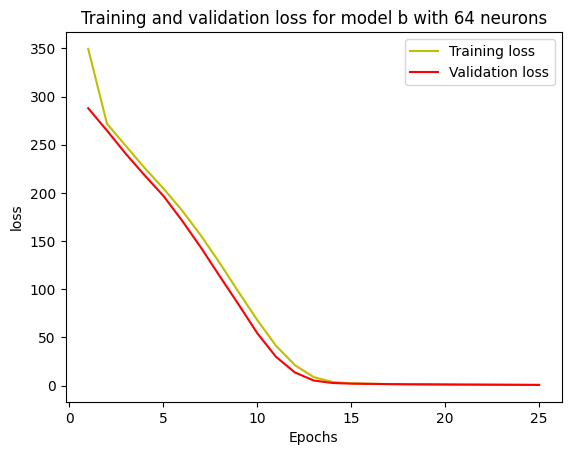

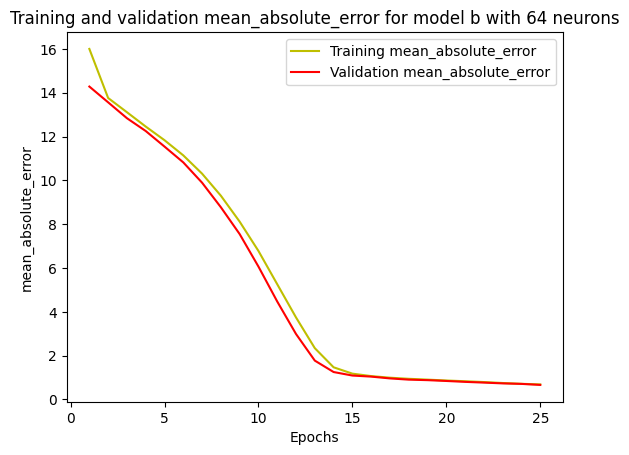

In [69]:
plot_metrics("loss", history_b_1, "b with 64 neurons")
plot_metrics("mean_absolute_error", history_b_1, "b with 64 neurons")

Предсказание на тестовой выборке

In [74]:
y_pred_b_1 = model_b_1.predict(X_test_rnn)

544/544 [==============================] - 1s 2ms/step


Вычисление метрик

In [75]:
# Вычисление метрик
r2_b_1 = r2_score(y_test, y_pred_b_1)
mse_b_1 = mean_squared_error(y_test, y_pred_b_1)
mae_b_1 = mean_absolute_error(y_test, y_pred_b_1)

In [76]:
# Вывод метрик
print(f'R^2 Score: {r2_b_1}')
print(f'Mean Squared Error: {mse_b_1}')
print(f'Mean Absolute Error: {mae_b_1}')

R^2 Score: 0.9985527424570935
Mean Squared Error: 0.6734552807511591
Mean Absolute Error: 0.6601524578338174


Визуализируем предсказание на небольшом участке для наглядности

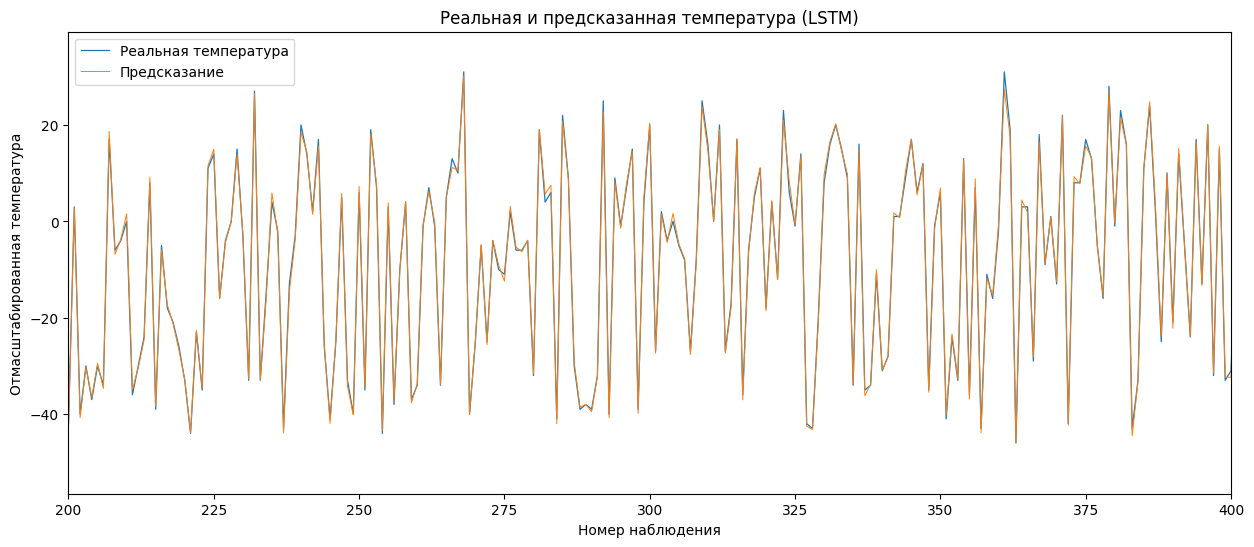

In [77]:
plot_result(y_test, y_pred_b_1, "LSTM", 200, 400)

## b) Регрессор, ячейку LSTM (или GRU) в скрытом слое

Построение модели

In [78]:
model_b_2 = Sequential([
    LSTM(units=8, activation="relu", input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dense(units=1, activation="linear")
])

Компиляция модели

In [79]:
model_b_2.compile(optimizer="adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

In [80]:
model_b_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 384       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 393 (1.54 KB)
Trainable params: 393 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели

In [81]:
history_b_2 = model_b_2.fit(X_train_rnn, y_train,
            epochs=30,
            batch_size=32,
            validation_data=(X_val_rnn, y_val))

Epoch 1/30
2539/2539 [==============================] - 17s 6ms/step - loss: 418.3123 - mean_absolute_error: 17.7276 - val_loss: 337.7296 - val_mean_absolute_error: 16.0445
Epoch 2/30
2539/2539 [==============================] - 8s 3ms/step - loss: 304.7277 - mean_absolute_error: 14.8985 - val_loss: 292.4376 - val_mean_absolute_error: 14.4285
Epoch 3/30
2539/2539 [==============================] - 9s 4ms/step - loss: 282.1694 - mean_absolute_error: 14.0703 - val_loss: 281.1844 - val_mean_absolute_error: 14.0679
Epoch 4/30
2539/2539 [==============================] - 9s 4ms/step - loss: 270.2010 - mean_absolute_error: 13.7206 - val_loss: 267.2138 - val_mean_absolute_error: 13.5946
Epoch 5/30
2539/2539 [==============================] - 10s 4ms/step - loss: 256.4934 - mean_absolute_error: 13.3292 - val_loss: 253.9628 - val_mean_absolute_error: 13.2496
Epoch 6/30
2539/2539 [==============================] - 10s 4ms/step - loss: 244.6136 - mean_absolute_error: 12.9858 - val_loss: 242.5875 

Визуализируем лосс и метрики MAE, MSE

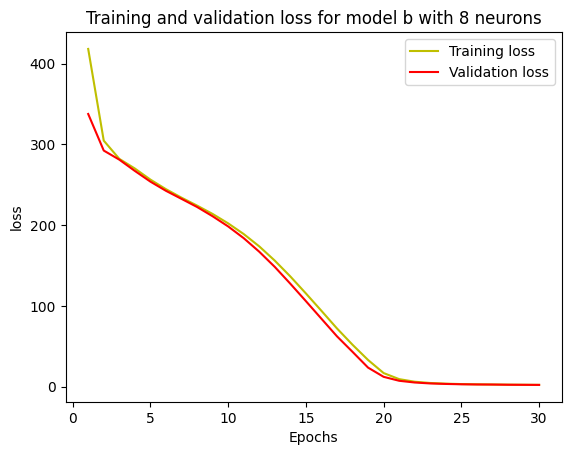

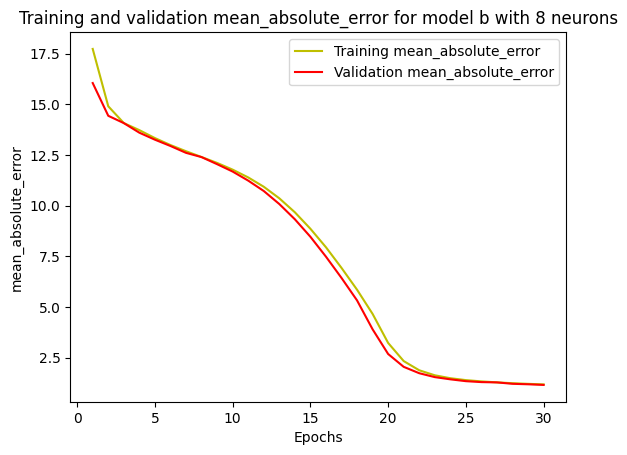

In [82]:
plot_metrics("loss", history_b_2, "b with 8 neurons")
plot_metrics("mean_absolute_error", history_b_2, "b with 8 neurons")

Предсказание на тестовой выборке

In [83]:
y_pred_b_2 = model_b_2.predict(X_test_rnn)

544/544 [==============================] - 1s 2ms/step


Вычисление метрик

In [84]:
# Вычисление метрик
r2_b_2 = r2_score(y_test, y_pred_b_2)
mse_b_2 = mean_squared_error(y_test, y_pred_b_2)
mae_b_2 = mean_absolute_error(y_test, y_pred_b_2)

In [85]:
# Вывод метрик
print(f'R^2 Score: {r2_b_2}')
print(f'Mean Squared Error: {mse_b_2}')
print(f'Mean Absolute Error: {mae_b_2}')

R^2 Score: 0.9953627762599573
Mean Squared Error: 2.1578487056868183
Mean Absolute Error: 1.1465169416260403


Визуализируем предсказание на небольшом участке для наглядности

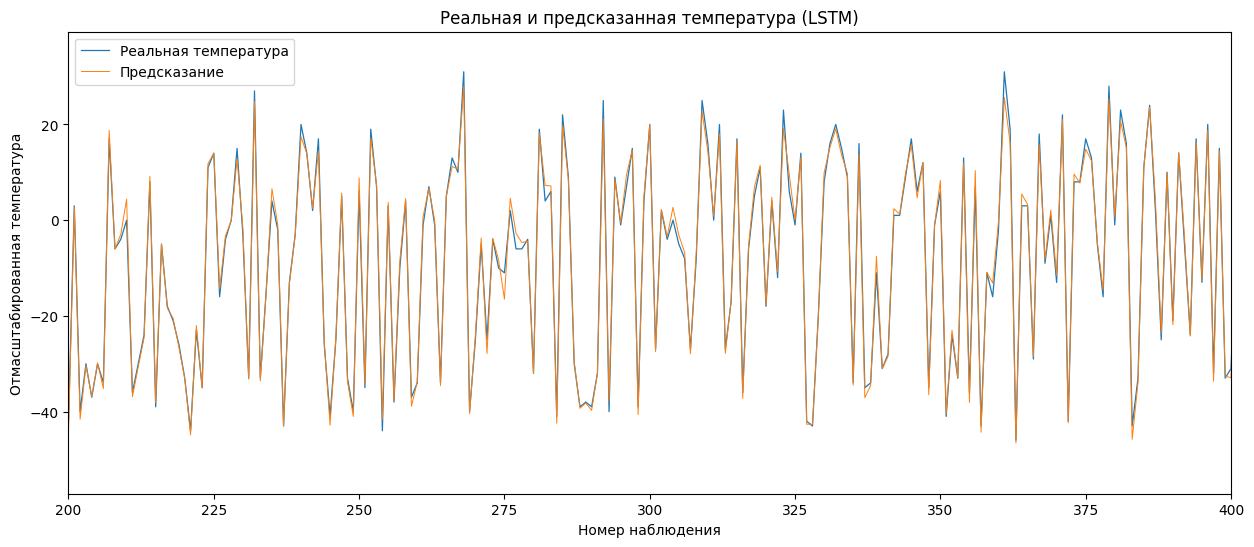

In [86]:
plot_result(y_test, y_pred_b_2, "LSTM", 200, 400)

Здесь все происходит аналогично модели a)

Попробуем добавить `dropout`

Построение модели

In [92]:
model_b_dropout = Sequential([
    LSTM(units=8, activation="relu", input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.2),
    Dense(units=1, activation="linear")
])

Компиляция модели

In [93]:
model_b_dropout.compile(optimizer="adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

In [94]:
model_b_dropout.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 384       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 393 (1.54 KB)
Trainable params: 393 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели

In [95]:
history_b_dropout = model_b_dropout.fit(X_train_rnn, y_train,
            epochs=60,
            batch_size=32,
            validation_data=(X_val_rnn, y_val))

Epoch 1/60
2539/2539 [==============================] - 13s 3ms/step - loss: 429.6673 - mean_absolute_error: 17.9750 - val_loss: 355.1945 - val_mean_absolute_error: 16.5137
Epoch 2/60
2539/2539 [==============================] - 11s 4ms/step - loss: 343.3014 - mean_absolute_error: 15.8263 - val_loss: 305.2530 - val_mean_absolute_error: 14.9005
Epoch 3/60
2539/2539 [==============================] - 9s 3ms/step - loss: 314.0296 - mean_absolute_error: 14.8842 - val_loss: 287.9015 - val_mean_absolute_error: 14.3157
Epoch 4/60
2539/2539 [==============================] - 15s 6ms/step - loss: 298.8174 - mean_absolute_error: 14.4480 - val_loss: 273.7133 - val_mean_absolute_error: 13.9140
Epoch 5/60
2539/2539 [==============================] - 9s 3ms/step - loss: 284.5618 - mean_absolute_error: 14.0743 - val_loss: 260.6006 - val_mean_absolute_error: 13.4959
Epoch 6/60
2539/2539 [==============================] - 9s 3ms/step - loss: 273.6555 - mean_absolute_error: 13.7956 - val_loss: 250.8641 

Визуализируем лосс и метрики MAE, MSE

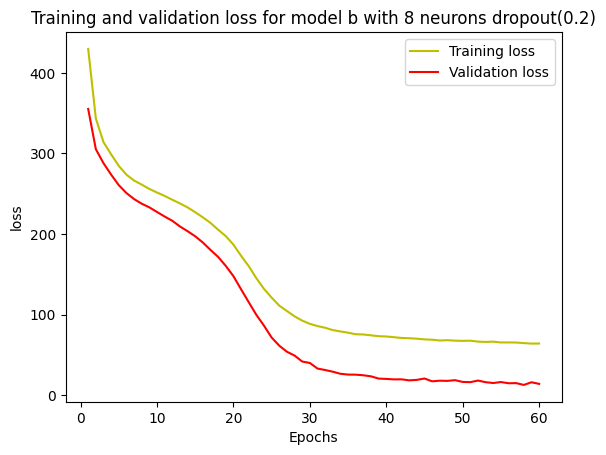

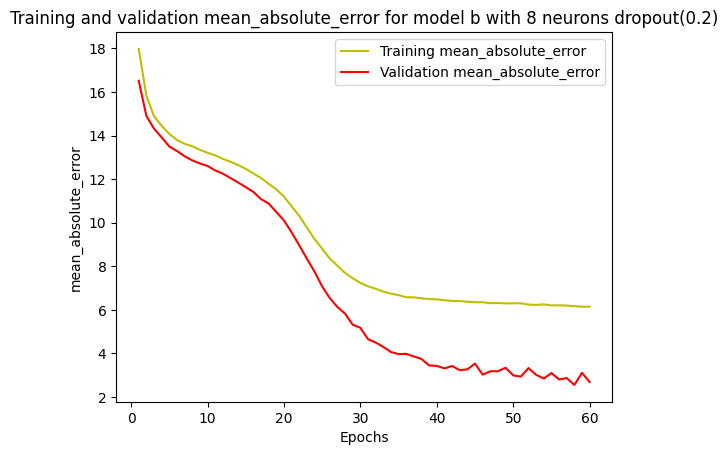

In [96]:
plot_metrics("loss", history_b_dropout, "b with 8 neurons dropout(0.2)")
plot_metrics("mean_absolute_error", history_b_dropout, "b with 8 neurons dropout(0.2)")

Предсказание на тестовой выборке

In [97]:
y_pred_b_dropout = model_b_dropout.predict(X_test_rnn)

544/544 [==============================] - 1s 2ms/step


Вычисление метрик

In [98]:
# Вычисление метрик
r2_b_dropout = r2_score(y_test, y_pred_b_dropout)
mse_b_dropout = mean_squared_error(y_test, y_pred_b_dropout)
mae_b_dropout = mean_absolute_error(y_test, y_pred_b_dropout)

In [99]:
# Вывод метрик
print(f'R^2 Score: {r2_b_dropout}')
print(f'Mean Squared Error: {mse_b_dropout}')
print(f'Mean Absolute Error: {mae_b_dropout}')

R^2 Score: 0.9704326679316868
Mean Squared Error: 13.758626456448232
Mean Absolute Error: 2.6587974665090575


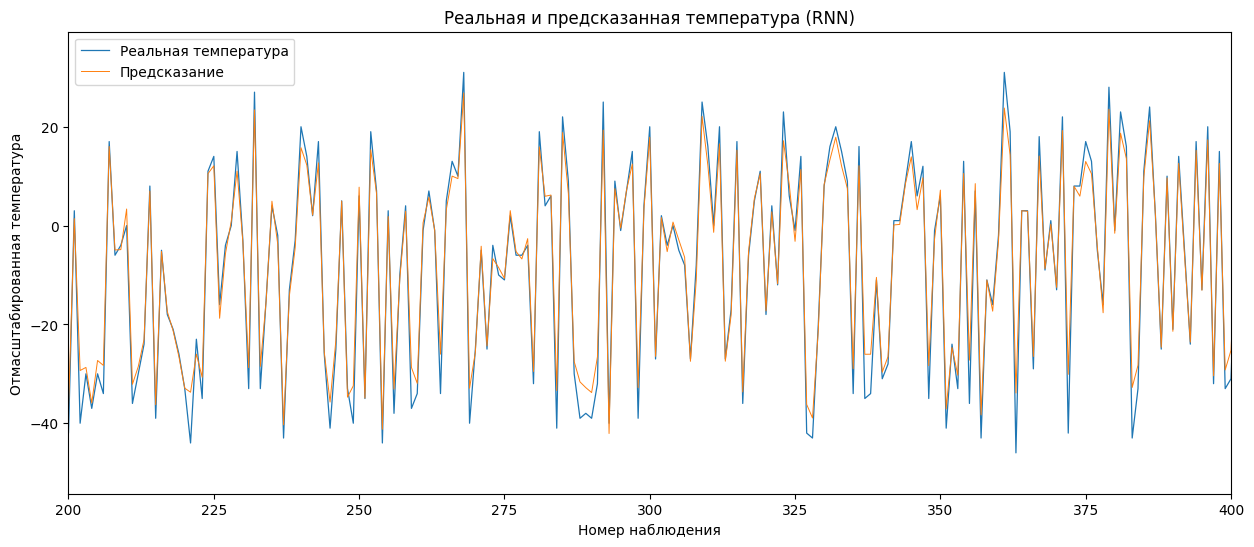

In [100]:
plot_result(y_test, y_pred_b_dropout, "RNN", 200, 400)

Аналогично предыдущей модели я думаю, что здесь dropout излишен

#c)

## c) Регрессор – стек двух слоёв с LSTM (или GRU)

Построение модели

In [101]:
model_c_1 = Sequential([
    LSTM(units=64, activation="relu", return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    LSTM(units=64, activation='relu'),
    Dense(units=1, activation="linear")
])

Компиляция модели

In [102]:
model_c_1.compile(optimizer="adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

In [103]:
model_c_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 64)             17408     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 50497 (197.25 KB)
Trainable params: 50497 (197.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели

In [104]:
history_c_1 = model_c_1.fit(X_train_rnn, y_train,
            epochs=15,
            batch_size=32,
            validation_data=(X_val_rnn, y_val))

Epoch 1/15
2539/2539 [==============================] - 19s 6ms/step - loss: 270.2611 - mean_absolute_error: 13.6123 - val_loss: 208.1606 - val_mean_absolute_error: 11.8584
Epoch 2/15
2539/2539 [==============================] - 19s 7ms/step - loss: 118.2115 - mean_absolute_error: 8.3605 - val_loss: 9.3242 - val_mean_absolute_error: 2.4701
Epoch 3/15
2539/2539 [==============================] - 17s 7ms/step - loss: 3.1467 - mean_absolute_error: 1.3073 - val_loss: 1.7567 - val_mean_absolute_error: 1.0060
Epoch 4/15
2539/2539 [==============================] - 19s 7ms/step - loss: 1.6071 - mean_absolute_error: 0.9796 - val_loss: 1.3041 - val_mean_absolute_error: 0.9099
Epoch 5/15
2539/2539 [==============================] - 16s 6ms/step - loss: 1.2764 - mean_absolute_error: 0.8891 - val_loss: 1.0347 - val_mean_absolute_error: 0.8139
Epoch 6/15
2539/2539 [==============================] - 16s 6ms/step - loss: 1.0656 - mean_absolute_error: 0.8179 - val_loss: 0.7180 - val_mean_absolute_erro

Визуализируем лосс и метрики MAE, MSE

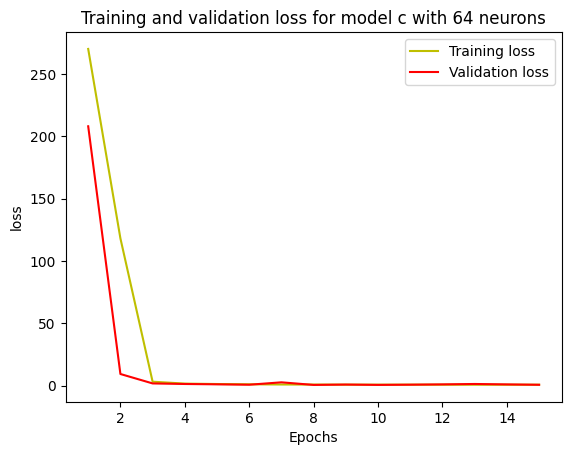

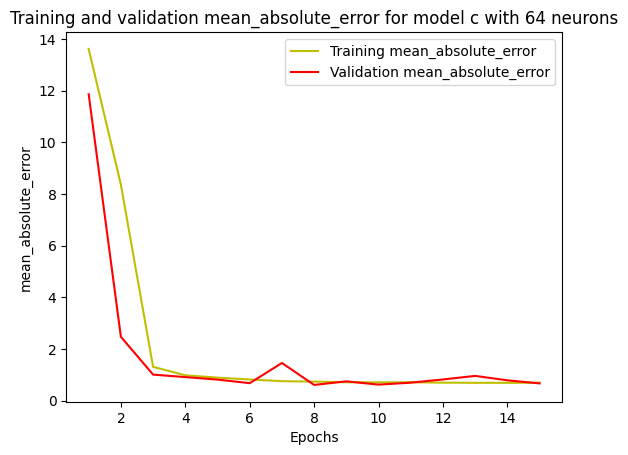

In [105]:
plot_metrics("loss", history_c_1, "c with 64 neurons")
plot_metrics("mean_absolute_error", history_c_1, "c with 64 neurons")

Предсказание на тестовой выборке

In [106]:
y_pred_c_1 = model_c_1.predict(X_test_rnn)

544/544 [==============================] - 2s 3ms/step


Вычисление метрик

In [107]:
# Вычисление метрик
r2_c_1 = r2_score(y_test, y_pred_c_1)
mse_c_1 = mean_squared_error(y_test, y_pred_c_1)
mae_c_1 = mean_absolute_error(y_test, y_pred_c_1)

In [108]:
# Вывод метрик
print(f'R^2 Score: {r2_c_1}')
print(f'Mean Squared Error: {mse_c_1}')
print(f'Mean Absolute Error: {mae_c_1}')

R^2 Score: 0.9985546108880514
Mean Squared Error: 0.6725858399929819
Mean Absolute Error: 0.6680797320063647


Визуализируем предсказание на небольшом участке для наглядности

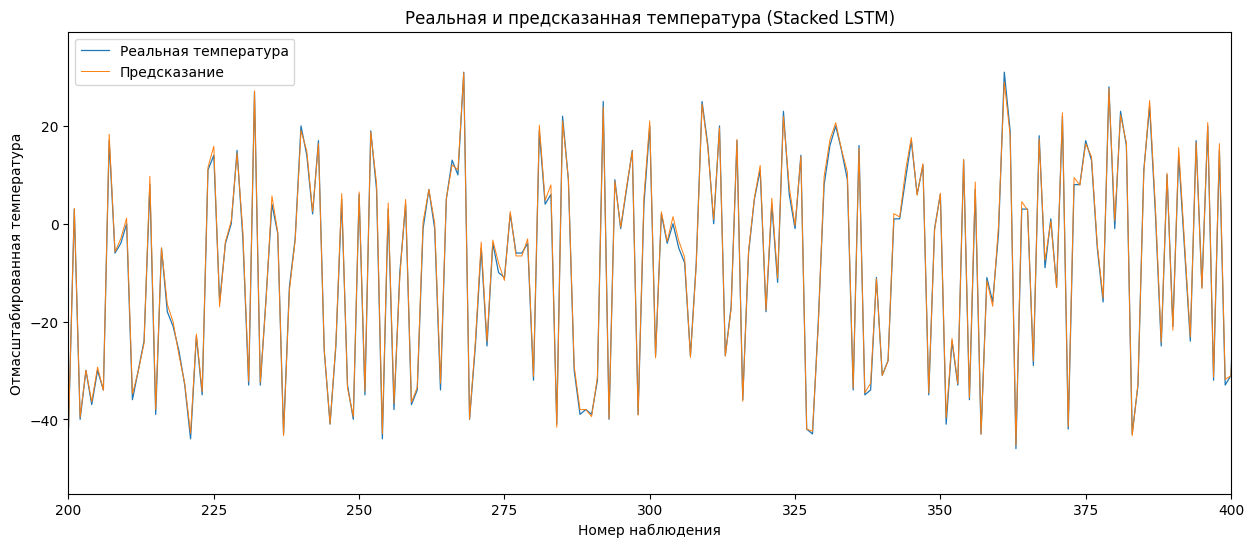

In [109]:
plot_result(y_test, y_pred_c_1, "Stacked LSTM", 200, 400)

## c) Регрессор – стек двух слоёв с LSTM (или GRU)

Построение модели

In [110]:
model_c_2 = Sequential([
    LSTM(units=8, activation="relu", return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    LSTM(units=8, activation='relu'),
    Dense(units=1, activation="linear")
])

Компиляция модели

In [111]:
model_c_2.compile(optimizer="adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

In [112]:
model_c_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 8)              384       
                                                                 
 lstm_7 (LSTM)               (None, 8)                 544       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 937 (3.66 KB)
Trainable params: 937 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели

In [113]:
history_c_2 = model_c_2.fit(X_train_rnn, y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_val_rnn, y_val))

Epoch 1/25
2539/2539 [==============================] - 17s 5ms/step - loss: 345.8477 - mean_absolute_error: 15.8399 - val_loss: 287.6458 - val_mean_absolute_error: 14.1155
Epoch 2/25
2539/2539 [==============================] - 13s 5ms/step - loss: 275.6540 - mean_absolute_error: 13.7638 - val_loss: 272.2998 - val_mean_absolute_error: 13.5975
Epoch 3/25
2539/2539 [==============================] - 12s 5ms/step - loss: 260.8675 - mean_absolute_error: 13.3194 - val_loss: 256.1851 - val_mean_absolute_error: 13.2082
Epoch 4/25
2539/2539 [==============================] - 11s 4ms/step - loss: 238.7768 - mean_absolute_error: 12.7218 - val_loss: 224.1033 - val_mean_absolute_error: 12.2465
Epoch 5/25
2539/2539 [==============================] - 13s 5ms/step - loss: 184.7042 - mean_absolute_error: 11.2195 - val_loss: 134.5834 - val_mean_absolute_error: 9.7313
Epoch 6/25
2539/2539 [==============================] - 12s 5ms/step - loss: 74.0498 - mean_absolute_error: 6.9735 - val_loss: 29.3950 -

Визуализируем лосс и метрики MAE, MSE

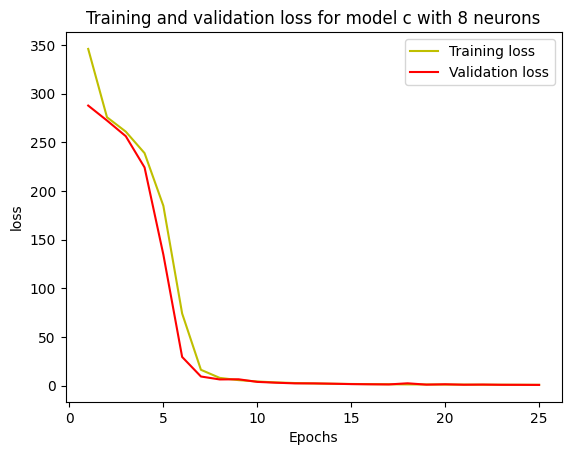

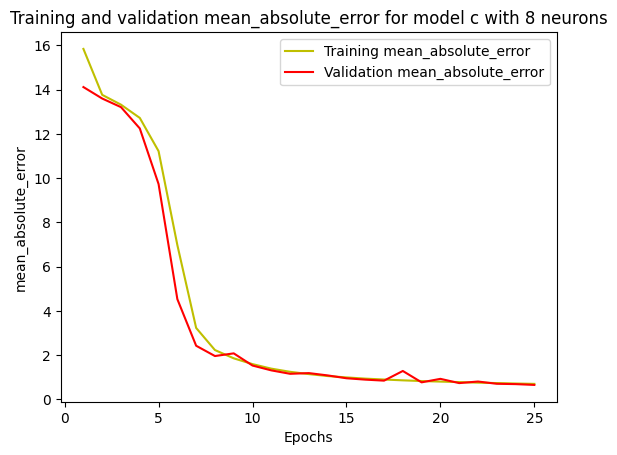

In [114]:
plot_metrics("loss", history_c_2, "c with 8 neurons")
plot_metrics("mean_absolute_error", history_c_2, "c with 8 neurons")

Предсказание на тестовой выборке

In [115]:
y_pred_c_2 = model_c_2.predict(X_test_rnn)

544/544 [==============================] - 2s 3ms/step


Вычисление метрик

In [116]:
# Вычисление метрик
r2_c_2 = r2_score(y_test, y_pred_c_2)
mse_c_2 = mean_squared_error(y_test, y_pred_c_2)
mae_c_2 = mean_absolute_error(y_test, y_pred_c_2)

In [117]:
# Вывод метрик
print(f'R^2 Score: {r2_c_2}')
print(f'Mean Squared Error: {mse_c_2}')
print(f'Mean Absolute Error: {mae_c_2}')

R^2 Score: 0.9985838157233938
Mean Squared Error: 0.658995894871466
Mean Absolute Error: 0.651214677913449


Визуализируем предсказание на небольшом участке для наглядности

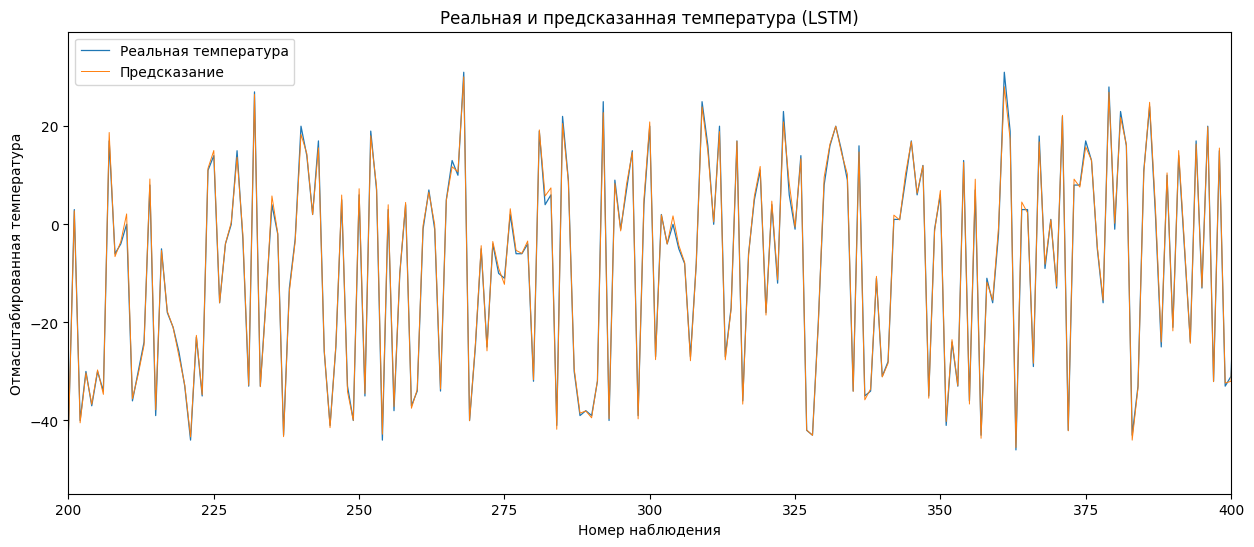

In [118]:
plot_result(y_test, y_pred_c_2, "LSTM", 200, 400)

In [119]:
print(f'R^2 Score:\t\t1) {r2_c_1}\t2) {r2_c_2}')
print(f'Mean Squared Error:\t1) {mse_c_1}\t2) {mse_c_2}')
print(f'Mean Absolute Error:\t1) {mae_c_1}\t2) {mae_c_2}')

R^2 Score:		1) 0.9985546108880514	2) 0.9985838157233938
Mean Squared Error:	1) 0.6725858399929819	2) 0.658995894871466
Mean Absolute Error:	1) 0.6680797320063647	2) 0.651214677913449


Stack для двух слоев LSTM с 64 нейронами в каждом, судя по метрикам, показывает себя лучше, чем модель с 8 нейронами и аналогичной архитектурой

Попробуем добавить `dropout` в последнюю

Построение модели

In [131]:
model_c_dropout = Sequential([
    LSTM(units=8, activation="relu", return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.2),
    LSTM(units=8, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation="linear")
])

Компиляция модели

In [132]:
model_c_dropout.compile(optimizer="adam", loss="mean_squared_error", metrics=['mean_absolute_error'])

In [133]:
model_c_dropout.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 8)              384       
                                                                 
 dropout_10 (Dropout)        (None, 1, 8)              0         
                                                                 
 lstm_15 (LSTM)              (None, 8)                 544       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 937 (3.66 KB)
Trainable params: 937 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели

In [134]:
history_c_dropout = model_c_dropout.fit(X_train_rnn, y_train,
            epochs=30,
            batch_size=32,
            validation_data=(X_val_rnn, y_val))

Epoch 1/30
2539/2539 [==============================] - 51s 8ms/step - loss: 393.8728 - mean_absolute_error: 16.9212 - val_loss: 296.2566 - val_mean_absolute_error: 14.5593
Epoch 2/30
2539/2539 [==============================] - 18s 7ms/step - loss: 304.6750 - mean_absolute_error: 14.5485 - val_loss: 271.6902 - val_mean_absolute_error: 13.7070
Epoch 3/30
2539/2539 [==============================] - 18s 7ms/step - loss: 289.8471 - mean_absolute_error: 14.1257 - val_loss: 264.6666 - val_mean_absolute_error: 13.5342
Epoch 4/30
2539/2539 [==============================] - 16s 6ms/step - loss: 283.2623 - mean_absolute_error: 13.9521 - val_loss: 256.8672 - val_mean_absolute_error: 13.2904
Epoch 5/30
2539/2539 [==============================] - 17s 7ms/step - loss: 277.1860 - mean_absolute_error: 13.7752 - val_loss: 244.3843 - val_mean_absolute_error: 13.0202
Epoch 6/30
2539/2539 [==============================] - 17s 7ms/step - loss: 269.6017 - mean_absolute_error: 13.5769 - val_loss: 235.89

Визуализируем лосс и метрики MAE, MSE

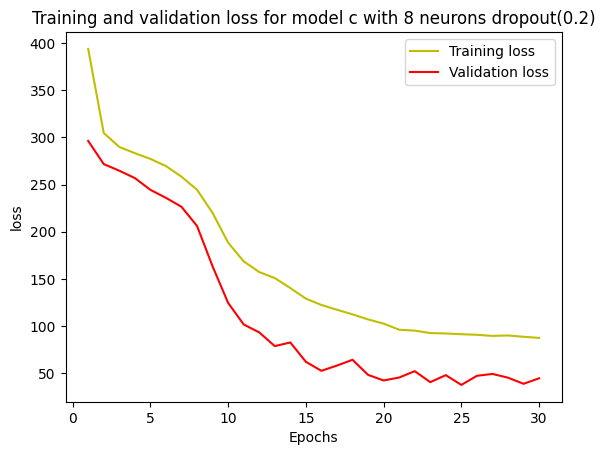

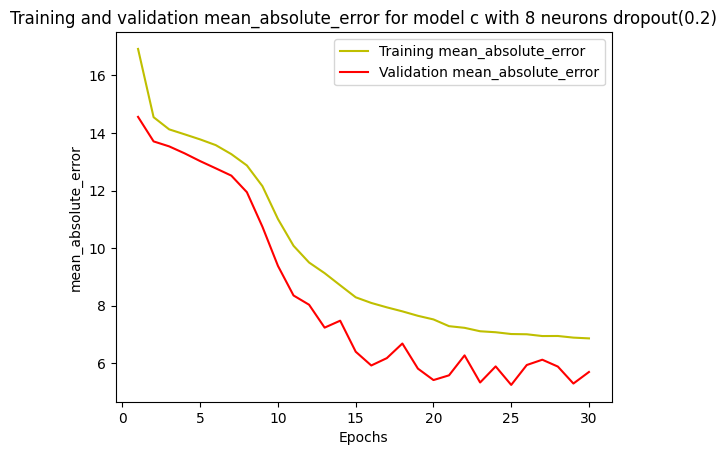

In [137]:
plot_metrics("loss", history_c_dropout, "c with 8 neurons dropout(0.2)")
plot_metrics("mean_absolute_error", history_c_dropout, "c with 8 neurons dropout(0.2)")

Предсказание на тестовой выборке

In [138]:
y_pred_c_dropout = model_c_dropout.predict(X_test_rnn)

544/544 [==============================] - 2s 3ms/step


Вычисление метрик

In [139]:
# Вычисление метрик
r2_c_dropout = r2_score(y_test, y_pred_c_dropout)
mse_c_dropout = mean_squared_error(y_test, y_pred_c_dropout)
mae_c_dropout = mean_absolute_error(y_test, y_pred_c_dropout)

In [140]:
# Вывод метрик
print(f'R^2 Score: {r2_c_dropout}')
print(f'Mean Squared Error: {mse_c_dropout}')
print(f'Mean Absolute Error: {mae_c_dropout}')

R^2 Score: 0.9048702159001201
Mean Squared Error: 44.26693491617034
Mean Absolute Error: 5.695030490157865


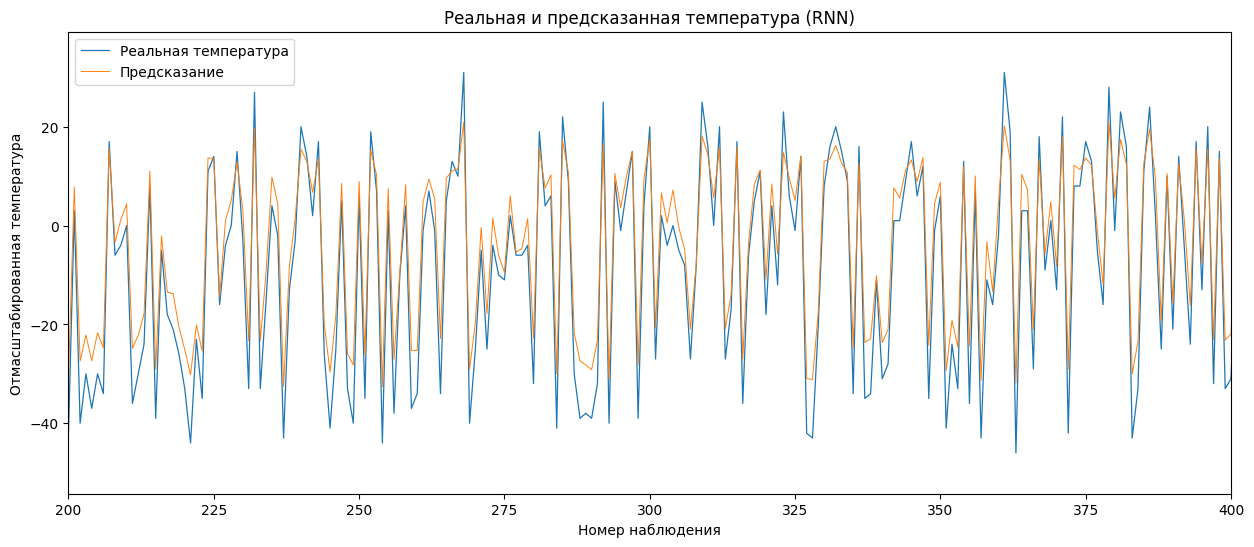

In [141]:
plot_result(y_test, y_pred_c_dropout, "RNN", 200, 400)

Аналогично предыдущей модели я думаю, что здесь dropout излишен